In [2]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))

466
156


In [3]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [4]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [55]:
import torch

train_rest_ts_t = torch.from_numpy(np.stack(train_rest_ts)).float()
test_rest_ts_t = torch.from_numpy(np.stack(test_rest_ts)).float()

def process(ts, ws):
    nw = int(ts.shape[2]/ws)
    slices = []
    for i in range(nw):
        slc = ts[:,:,i*ws:ws*(i+1)]
        slices.append(slc)
    dists = []
    dists.append(torch.einsum('nat,nbt->nab', slices[0], slices[0]))
    for i in range(1,nw):
#         dists.append(torch.cdist(slices[i-1], slices[i]))
        dists.append(torch.einsum('nat,nbt->nab', slices[i-1], slices[i]))
    return torch.stack(dists, dim=3)

print(train_rest_ts_t.shape)

torch.Size([466, 264, 124])


In [57]:
import Reshape

nTrain = len(train_rest_ts)
nRoi = train_rest_ts[0].shape[0]
nC = int(nRoi*(nRoi+1)/2)
nD = 12

train_rest_dist = process(train_rest_ts_t, 10).numpy()
# train_rest_dist2 = train_rest_dist.reshape(466,264*264,3)
train_rest_dist2 = np.zeros([nTrain, nC, nD], dtype='float32')
_ = Reshape.Reshape(train_rest_dist, train_rest_dist2)

print(train_rest_dist2.shape)

train_rest_dist2_t = torch.from_numpy(train_rest_dist2).float().cuda()

print('Complete')

(466, 34980, 12)
Complete


In [58]:
nTest = len(test_rest_ts)

test_rest_dist = process(test_rest_ts_t, 10).numpy()
test_rest_dist2 = np.zeros([nTest, nC, nD], dtype='float32')
_ = Reshape.Reshape(test_rest_dist, test_rest_dist2)

print(test_rest_dist2.shape)

test_rest_dist2_t = torch.from_numpy(test_rest_dist2).float().cuda()

print('Complete')

(156, 34980, 12)
Complete


In [59]:
print(train_rest_dist[0,1,0:10,0])
print(train_rest_dist2[0,264:270,0])

[4.705374  3.189954  2.3700757 2.7551603 3.4150674 3.7285938 2.1008575
 2.4730358 4.3431735 1.3538336]
[3.189954  2.3700757 2.7551603 3.4150674 3.7285938 2.1008575]


In [60]:
print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Quadro K2200
Memory Usage:
Allocated: 1.3 GB
Cached:    2.7 GB


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class TVCD(nn.Module):
    def __init__(self):
        super(TVCD, self).__init__()
        self.mix1 = nn.Linear(3,50).cuda()
        self.mix2 = nn.Linear(50,50).cuda()
        self.mix3 = nn.Linear(50,3).cuda()
        
        self.rmix1 = nn.Linear(34980,50).cuda()
        self.rmix2 = nn.Linear(50,50).cuda()
        self.rmix3 = nn.Linear(50,1).cuda()
        
        self.fmix1 = nn.Linear(3,50).cuda()
        self.fmix2 = nn.Linear(50,50).cuda()
        self.fmix3 = nn.Linear(50,1).cuda()
        
        self.m = nn.Dropout(p=0.01)
        self.n = nn.Dropout(p=0.05)
        
    def forward(self, x):
        nB = x.shape[0]
        
        x = x.reshape(nB*nC,nD)
        x = self.m(F.relu(self.mix1(x)))
        x = F.relu(self.mix2(x))
        x = F.relu(self.mix3(x))
        
        x = x.reshape(nB,nC,nD)
        x = x.permute(0,2,1)
        x = self.n(F.relu(self.rmix1(x)))
        x = F.relu(self.rmix2(x))
        x = F.relu(self.rmix3(x))
        
        x = x.reshape(nB,nD)
        x = F.relu(self.fmix1(x))
        x = F.relu(self.fmix2(x))
        x = F.relu(self.fmix3(x))
        
        return x
    
tvcd = TVCD()
optim = torch.optim.Adam(tvcd.parameters(), lr=1e-3)
print('Complete')

Complete


In [64]:
class TVCD(nn.Module):
    def __init__(self):
        super(TVCD, self).__init__()
        self.fc1 = nn.Linear(34980,50).cuda()
        self.fc2 = nn.Linear(50,50).cuda()
        self.fc3 = nn.Linear(50,1).cuda()
        self.fcFinal = nn.Linear(12,1).cuda()
        self.dp = nn.Dropout(p=0)
        
    def forward(self, x):
        res = []
        for i in range(12):
            a = F.relu(self.fc1(self.dp(x[:,:,i])))
            a = F.relu(self.fc2(a))
            a = F.relu(self.fc3(a))
            res.append(a)
        a = torch.cat(res, dim=1)
        return self.fcFinal(a)
    
tvcd = TVCD()
optim = torch.optim.Adam(tvcd.parameters(), lr=1e-3)
print('Complete')

Complete


In [65]:
import random

running = 0
nEpoch = 1000
pPeriod = 50
nB = 10
N = train_rest_ts_t.shape[0]

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nB).float().cuda()
    for i in range(nB):
        idx = random.randint(0,N-1)
        batch.append(train_rest_dist2_t[idx])
        truth[i] = X_train[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = tvcd(batch).flatten()
    loss = torch.sum((pred-truth)**2)
    loss.backward()
    running += loss.detach().cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
        running = 0

print('Finished training')

epoch 0 loss=16.504745
epoch 50 loss=13.620021
epoch 100 loss=8.791100
epoch 150 loss=6.076037
epoch 200 loss=4.731006
epoch 250 loss=3.537194
epoch 300 loss=2.963223
epoch 350 loss=1.828485
epoch 400 loss=2.411083
epoch 450 loss=2.198653
epoch 500 loss=1.490634
epoch 550 loss=1.428025
epoch 600 loss=0.954341
epoch 650 loss=1.006605
epoch 700 loss=0.793517
epoch 750 loss=1.775079
epoch 800 loss=1.385521
epoch 850 loss=1.428909
epoch 900 loss=1.436713
epoch 950 loss=1.114159
epoch 999 loss=1.155017
Finished training


[[1.         0.04494717]
 [0.04494717 1.        ]]
6.951200517648683
5.804130087041448


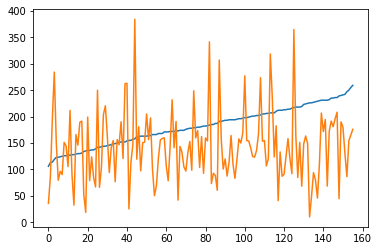

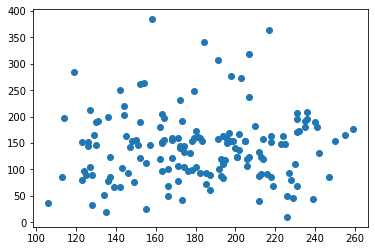

In [66]:
import matplotlib.pyplot as plt

predY = tvcd(test_rest_dist2_t).detach().cpu().numpy().flatten()

idcs = np.argsort(X_test[:,0])
yPred = predY[idcs]
y = X_test[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [50]:
train_rest_p_t = torch.from_numpy(
    np.stack([np.corrcoef(ts) for ts in train_rest_ts])).reshape(train_rest_ts_t.shape[0], 
                                                                 -1).float().cuda()
test_rest_p_t = torch.from_numpy(
    np.stack([np.corrcoef(ts) for ts in test_rest_ts])).reshape(test_rest_ts_t.shape[0], 
                                                                 -1).float().cuda()

print('Complete')

Complete


In [51]:
print(train_rest_p_t.shape)

torch.Size([466, 69696])


In [72]:
class DP(nn.Module):
    def __init__(self):
        super(DP, self).__init__()
        self.fc1 = nn.Linear(264*264,100).cuda()
        self.fc2 = nn.Linear(100,100).cuda()
        self.fc3 = nn.Linear(100,1).cuda()
        self.dp = nn.Dropout(p=0.05)
        
    def forward(self, x):
        doDp = x[0]
        x = x[1]
        if doDp:
            x = F.relu(self.fc1(self.dp(x)))
        else:
            x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
dp = DP()
optim = torch.optim.Adam(dp.parameters(), lr=1e-3)
print('Complete')

Complete


In [73]:
import random

running = 0
nEpoch = 5000
pPeriod = 100
nB = 20
N = train_rest_ts_t.shape[0]

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nB).float().cuda()
    for i in range(nB):
        idx = random.randint(0,N-1)
        batch.append(train_rest_p_t[idx])
        truth[i] = X_train[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = dp([True, batch]).flatten()
    loss = torch.sum((pred-truth)**2)
    loss.backward()
    running += loss.detach().cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
        running = 0

print('Finished training')

epoch 0 loss=15.955613
epoch 100 loss=5.864709
epoch 200 loss=2.676582
epoch 300 loss=1.974123
epoch 400 loss=1.240495
epoch 500 loss=0.905353
epoch 600 loss=0.615402
epoch 700 loss=0.485344
epoch 800 loss=0.382588
epoch 900 loss=0.283086
epoch 1000 loss=0.258140
epoch 1100 loss=0.198072
epoch 1200 loss=0.208467
epoch 1300 loss=0.211470
epoch 1400 loss=0.233177
epoch 1500 loss=0.354508
epoch 1600 loss=0.240965


KeyboardInterrupt: 

In [74]:
predY = dp([False, test_rest_p_t]).detach().cpu().numpy().flatten()

print(predY[0:10])

[168.80795  148.29868  180.41542  178.54881  191.1967   231.52553
 218.06134  118.126366 184.51205  103.439285]


[[1.         0.45535802]
 [0.45535802 1.        ]]
2.9753256672192587
2.3786059811583953


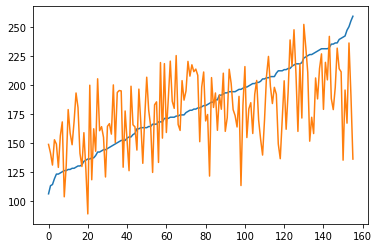

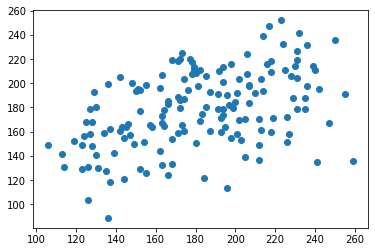

In [75]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test[:,0])
yPred = predY[idcs]
y = X_test[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [78]:
w, _, _, _ = np.linalg.lstsq(train_rest_p_t.cpu().numpy(), X_train[:,0], rcond=None)

print('Complete')

Complete


[[1.         0.50257959]
 [0.50257959 1.        ]]
2.7600557182218566
2.1853840772912028


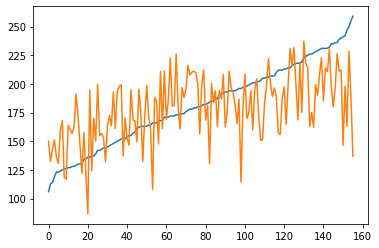

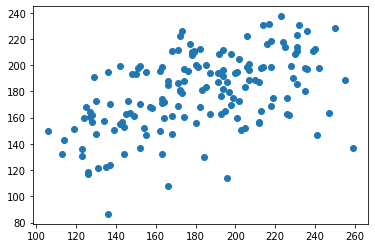

In [80]:
predY = test_rest_p_t.cpu().numpy()@w

idcs = np.argsort(X_test[:,0])
yPred = predY[idcs]
y = X_test[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()